In [7]:

import cv2
import csv
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import ast
import groupXY_functions as util
import skimage.morphology as morphology
from skimage.morphology import opening
from scipy import ndimage
import scipy

import path
import imutils
from tqdm import tqdm
from skimage.measure import label as sklabel

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000



TypeError: delta_e_cie2000() missing 2 required positional arguments: 'color1' and 'color2'

In [2]:
def rotate_bound(image ,angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = util.middle(image)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


In [3]:
def sym_detect(img):
    img[img > 0] = 255
    center = util.middle(img)
    first_half = img[:,:int(center[0])]
    second_half = img[:,int(center[0]):-1]
    _, first_size = first_half.shape
    _, second_size = second_half.shape
    if first_size > second_size:
        padd_rows = first_size-second_size
        second_half = np.pad(second_half,((0,0),(0,padd_rows)),"constant",constant_values=(0))
    elif first_size < second_size:
        padd_rows = abs(first_size-second_size)
        first_half = np.pad(first_half,((0,0),(padd_rows,0)),"constant",constant_values=0)
    #cv2.imshow("first_half", first_half)
    #cv2.imshow("second_half", second_half)
    flipped = cv2.flip(first_half, 1)
    #cv2.imshow("flipped 1", flipped )
    sum_mask = np.array(flipped) ^ np.array(second_half)
    sum_mask[sum_mask > 0]= 1
    #cv2.imshow("sum_mask", sum_mask )
    return np.sum(sum_mask)

In [4]:

def all_deg(thresh):
    list_ = []
    last_sym = 100000000000
    for i in tqdm(range(0, 180)):
        rotated_image = rotate_bound(thresh, i)
        sym = sym_detect(rotated_image)
        list_.append(sym)
        if sym < last_sym:
            last_sym = sym
            deg = i
    return (last_sym, np.average(list_))

In [5]:
def crop(img, cropped = []):
    if len(cropped) != 0:
        img = img[cropped[0]:cropped[1],cropped[2]:cropped[3]]
    return img

In [6]:

df = pd.read_csv(path.ground_truth)
df_out = pd.read_csv("out.csv")
df_out.at


thresh = cv2.imread(f'data/example_segmentation/ISIC_0001769_segmentation.png',0)
a,b,c,d = util.extract_bboxes(thresh)

cropThresh = thresh[a:b,c:d]
#cv2.imshow("test", cropThresh)
#cv2.imshow("rotated", rotate_bound(cropThresh,23))

_,th1 = cv2.threshold(rotate_bound(cropThresh,23),100,255,cv2.THRESH_BINARY)
center = [np.average(indices) for indices in np.where(th1 >= 255)]
print(center)
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(cropThresh)
ax[1].imshow(rotate_bound(cropThresh,23))

print(all_deg(cropThresh))


FileNotFoundError: [Errno 2] No such file or directory: 'out.csv'

In [ ]:
#df_out1 = df['image_id']
#df_out1['symmetry_min'] = None
#for index, line in df.iterrows():
#    id_ = line['image_id'] 
#    thresh = cv2.imread(path.segmentation+f'{id_}_segmentation.png',0)
#    a,b,c,d = util.extract_bboxes(thresh)
#    cropThresh = thresh[a:b,c:d]
#    df_out1.at[index,'symmetry_min'] = all_deg(cropThresh)

#df_out1.to_csv('sym.csv')

thresh = cv2.imread(f'data/symmetry-demo-images/triangle-mask.png',0)
a,b,c,d = util.extract_bboxes(thresh)

cropThresh = thresh[a:b,c:d]

print(all_deg(cropThresh))



In [ ]:
image1 = "ISIC_0003462"
mask1=plt.imread(f'data/example_segmentation/{image1}_segmentation.png')
im1 = plt.imread(f'data/red25/{image1}.jpg')
image2 = "ISIC_0003539"
mask2=plt.imread(f'data/example_segmentation/{image2}_segmentation.png')
im2 = plt.imread(f'data/red25/{image2}.jpg')

In [ ]:

def extract_mask_roi(image, mask, magnitude):
    '''
    Function to extract the region of interest from the image and mask.
    The input is the original image and the original mask
    The function returns the region of interest as a new numpy array.
    '''
    # Get region of interest from original mask
    # Replace the non-lesion pixels
    im_roi = image.copy()
    # If the mask is black at a pixel, set image color to black at that same pixel
    im_roi[mask==0] = 0

    # Turn the region of interest into gray
    im_gray = cv2.cvtColor(im_roi, cv2.COLOR_BGR2GRAY)

    # Create our custom mask with pixels that are lower than 95
    custom_mask = im_gray < magnitude
    # Generate a flask disk-shaped footprint
    struct_el = morphology.disk(10)

    # Apply the footprint to the custom mask
    opened = opening(custom_mask, struct_el)

    # Show only the opened mask on the entire image
    im_roi_opened = im_roi.copy()
    im_roi_opened[opened==0] = 0
    

    return im_roi_opened, custom_mask

In [ ]:
im_roi_opened,_ = extract_mask_roi(im1, mask1,140)
plt.imshow(im_roi_opened)

In [ ]:
im_roi_opened, _ = extract_mask_roi(im2, mask2,80)
plt.imshow(_)

In [ ]:
def boundry_check(image,mask):
    magnitude_list = [80,100]
    boundry_unfiltered, boundry_mask = extract_mask_roi(image,mask, magnitude_list[1])
    darkest_part, dark_mask = extract_mask_roi(image,mask, magnitude_list[0])
    
    
    boundry_mask_proper = ((np.abs(np.invert(boundry_mask)*1-mask)).astype(int))
    darkest_part_mask = (np.abs(np.invert(dark_mask)*1-mask)).astype(int)
    
    
    true_boundry = boundry_mask_proper - darkest_part_mask
    only_skin_mask = mask - boundry_mask_proper
    
    skin = image.copy()
    skin[only_skin_mask.astype(int) == 0] = 0
    
    boundry = image.copy()
    boundry[true_boundry.astype(int) == 0] = 0
    
    dark_part = image.copy()
    dark_part[darkest_part_mask.astype(int)== 0] = 0
    
    average_dark = averageColorsSimple(dark_part)
    average_boundry = averageColorsSimple(boundry)
    average_skin = averageColorsSimple(skin)
    
    return average_dark, average_boundry, average_skin
    

In [13]:
def averageColorsSimple(img):
    non_black = np.any(img != [0, 0, 0], axis=-1)
    average_ = np.average(img[non_black], axis=0)
    return average_

In [ ]:
image2 = "ISIC_0003539"
mask2=cv2.imread(f'data/example_segmentation/{image2}_segmentation.png')
im2 = cv2.imread(f'data/example_image/{image2}.jpg')
x = boundry_check(im2, mask2)

print(x)


In [ ]:
fig, ax = plt.subplots(ncols = 3)
print(x, np.array(x).shape)

In [ ]:

df = pd.read_csv(path.ground_truth)

def edge_check(mask):
    top = np.unique(mask[0,:])
    left = np.unique(mask[:,0])
    right = np.unique(mask[:,-1])
    bottom = np.unique(mask[-1,:])
    if (len(top) > 1) or  (len(left) > 1) or  (len(right) > 1) or  (len(bottom) > 1):
        return True
    
    

In [ ]:
img = cv2.imread(f'data/example_segmentation/ISIC_0001769_segmentation.png',0)
a,b,c,d = util.extract_bboxes(img)
all_de = []
test = []

cropThresh = img[a:b,c:d]
df = pd.read_csv(path.ground_truth)
for index, line in df.iterrows():
    id_ = line['image_id'] 
    thresh = cv2.imread(path.segmentation+f'{id_}_segmentation.png',0)
    if edge_check(thresh) != True:        
        a,b,c,d = util.extract_bboxes(thresh)
        cropThresh = thresh[a:b,c:d]
        print(id_)
        x,z = all_deg(cropThresh)
        all_de.append((x,np.average(z)))
        
        
    else:
        all_de.append("max")


print(all_de)


ISIC_0001769


100%|██████████| 180/180 [00:00<00:00, 309.16it/s]


ISIC_0001852


100%|██████████| 180/180 [00:00<00:00, 577.68it/s]

[(13985, 40728.42222222222), (5962, 22624.772222222222)]


In [ ]:
img = cv2.imread('data/example_segmentation/ISIC_0003657_segmentation.png',0)
a,b,c,d = util.extract_bboxes(img)
cropThresh = img[a:b,c:d]
print(all_deg(cropThresh))

print(np.unique(img))

100%|██████████| 180/180 [00:00<00:00, 244.74it/s]

(23269, 90)
[  0 255]


In [10]:
def extract_mask_roi2(image, mask, lower_bound, upper_bound):
    '''
    Function to extract the region of interest from the image and mask.
    The input is the original image, the original mask and the threshold value.
    The function returns the region of interest as a new numpy array.
    '''
    # NOTE: Images that are taken as very close ups (ISIC_0014712.jpg for example) will return the most prominent color as the color in the legion, and thus not cut out the skin color
    
    # Get the most dominant color in the image
    # https://stackoverflow.com/a/50900143/8660908
    a2D = image.reshape(-1,image.shape[-1])
    col_range = (256, 256, 256)
    a1D = np.ravel_multi_index(a2D.T, col_range)
    color_range = np.unravel_index(np.bincount(a1D).argmax(), col_range)
    # Add some upper and lower bounds for the color range
    # Make sure lower and upper are within the color range
    lower = np.maximum(np.array(color_range) - lower_bound, 0)
    upper = np.minimum(np.array(color_range) + upper_bound, 255)


    # Show only the original mask on the entire image
    im_roi_opened = image.copy()
    im_roi_opened[mask==0] = 0

    # Remove everything that is not in the range
    # This should amount to the skin being removed
    cv_mask = cv2.inRange(im_roi_opened, lower, upper)
    # cv_image = cv2.bitwise_not(im_roi_opened, im_roi_opened, mask = cv_mask)
    cv_image = im_roi_opened.copy()
    cv_image[cv_mask!=0] = 0

    # Get the biggest connected component
    # https://stackoverflow.com/a/63842045/8660908
    img_bw = cv_image > 0
    labels = sklabel(img_bw, return_num=False)
    maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=img_bw.flat))

    # Apply the maxCC_nobcg mask to the cv_image
    cv_image_nobcg = cv_image.copy()
    cv_image_nobcg[maxCC_nobcg==0] = 0

    # Turn cropped mask image into grayscale
    cv_image_nobcg_gray = cv2.cvtColor(cv_image_nobcg, cv2.COLOR_BGR2GRAY)
    # Turn into black and white
    cv_image_nobcg_mask = cv_image_nobcg_gray > 0 # > 0 because of the grayscale

    # Return image and mask
    return cv_image_nobcg, cv_image_nobcg_mask

(array([False,  True]), array([5865190,  231194]))


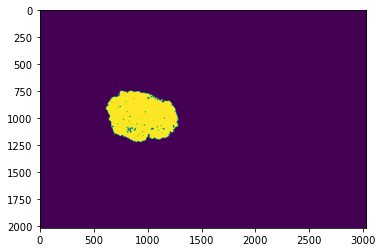

In [ ]:
mask = plt.imread('data/example_segmentation/ISIC_0003657_segmentation.png',0)
img =plt.imread('data/example_image/ISIC_0003657.jpg',0)


x,y= extract_mask_roi2(img, mask,50,50)

print(np.unique(y, return_counts = True))


plt.imshow(y)


In [9]:

def boundry_check2(image,mask, upper, lower):
    boundry_unfiltered, boundry_mask = extract_mask_roi2(image,mask, 20,20)
    darkest_part, dark_mask = extract_mask_roi2(image,mask, 40,40)
    

    boundry_mask[boundry_mask > 0] = 1
    dark_mask[dark_mask > 0] = 1    
    boundry_mask_proper = ((np.abs((boundry_mask)*1)).astype(int))
    darkest_part_mask = (np.abs((dark_mask)*1)).astype(int)
    
    
    true_boundry = boundry_mask_proper - darkest_part_mask
    only_skin_mask = np.invert(boundry_mask)
    
    skin = image.copy()
    skin[only_skin_mask.astype(int) == 0] = [0,0,0]
    
    boundry = image.copy()
    boundry[true_boundry.astype(int) == 0] = [0,0,0]
    
    dark_part = image.copy()
    dark_part[darkest_part_mask.astype(int)== 0] = [0,0,0]
    
    average_dark = averageColorsSimple(dark_part)
    average_boundry = averageColorsSimple(boundry)
    average_skin = averageColorsSimple(skin)
    
    return average_dark, average_boundry, average_skin

<bound method Figure.tight_layout of <Figure size 2160x2160 with 15 Axes>>

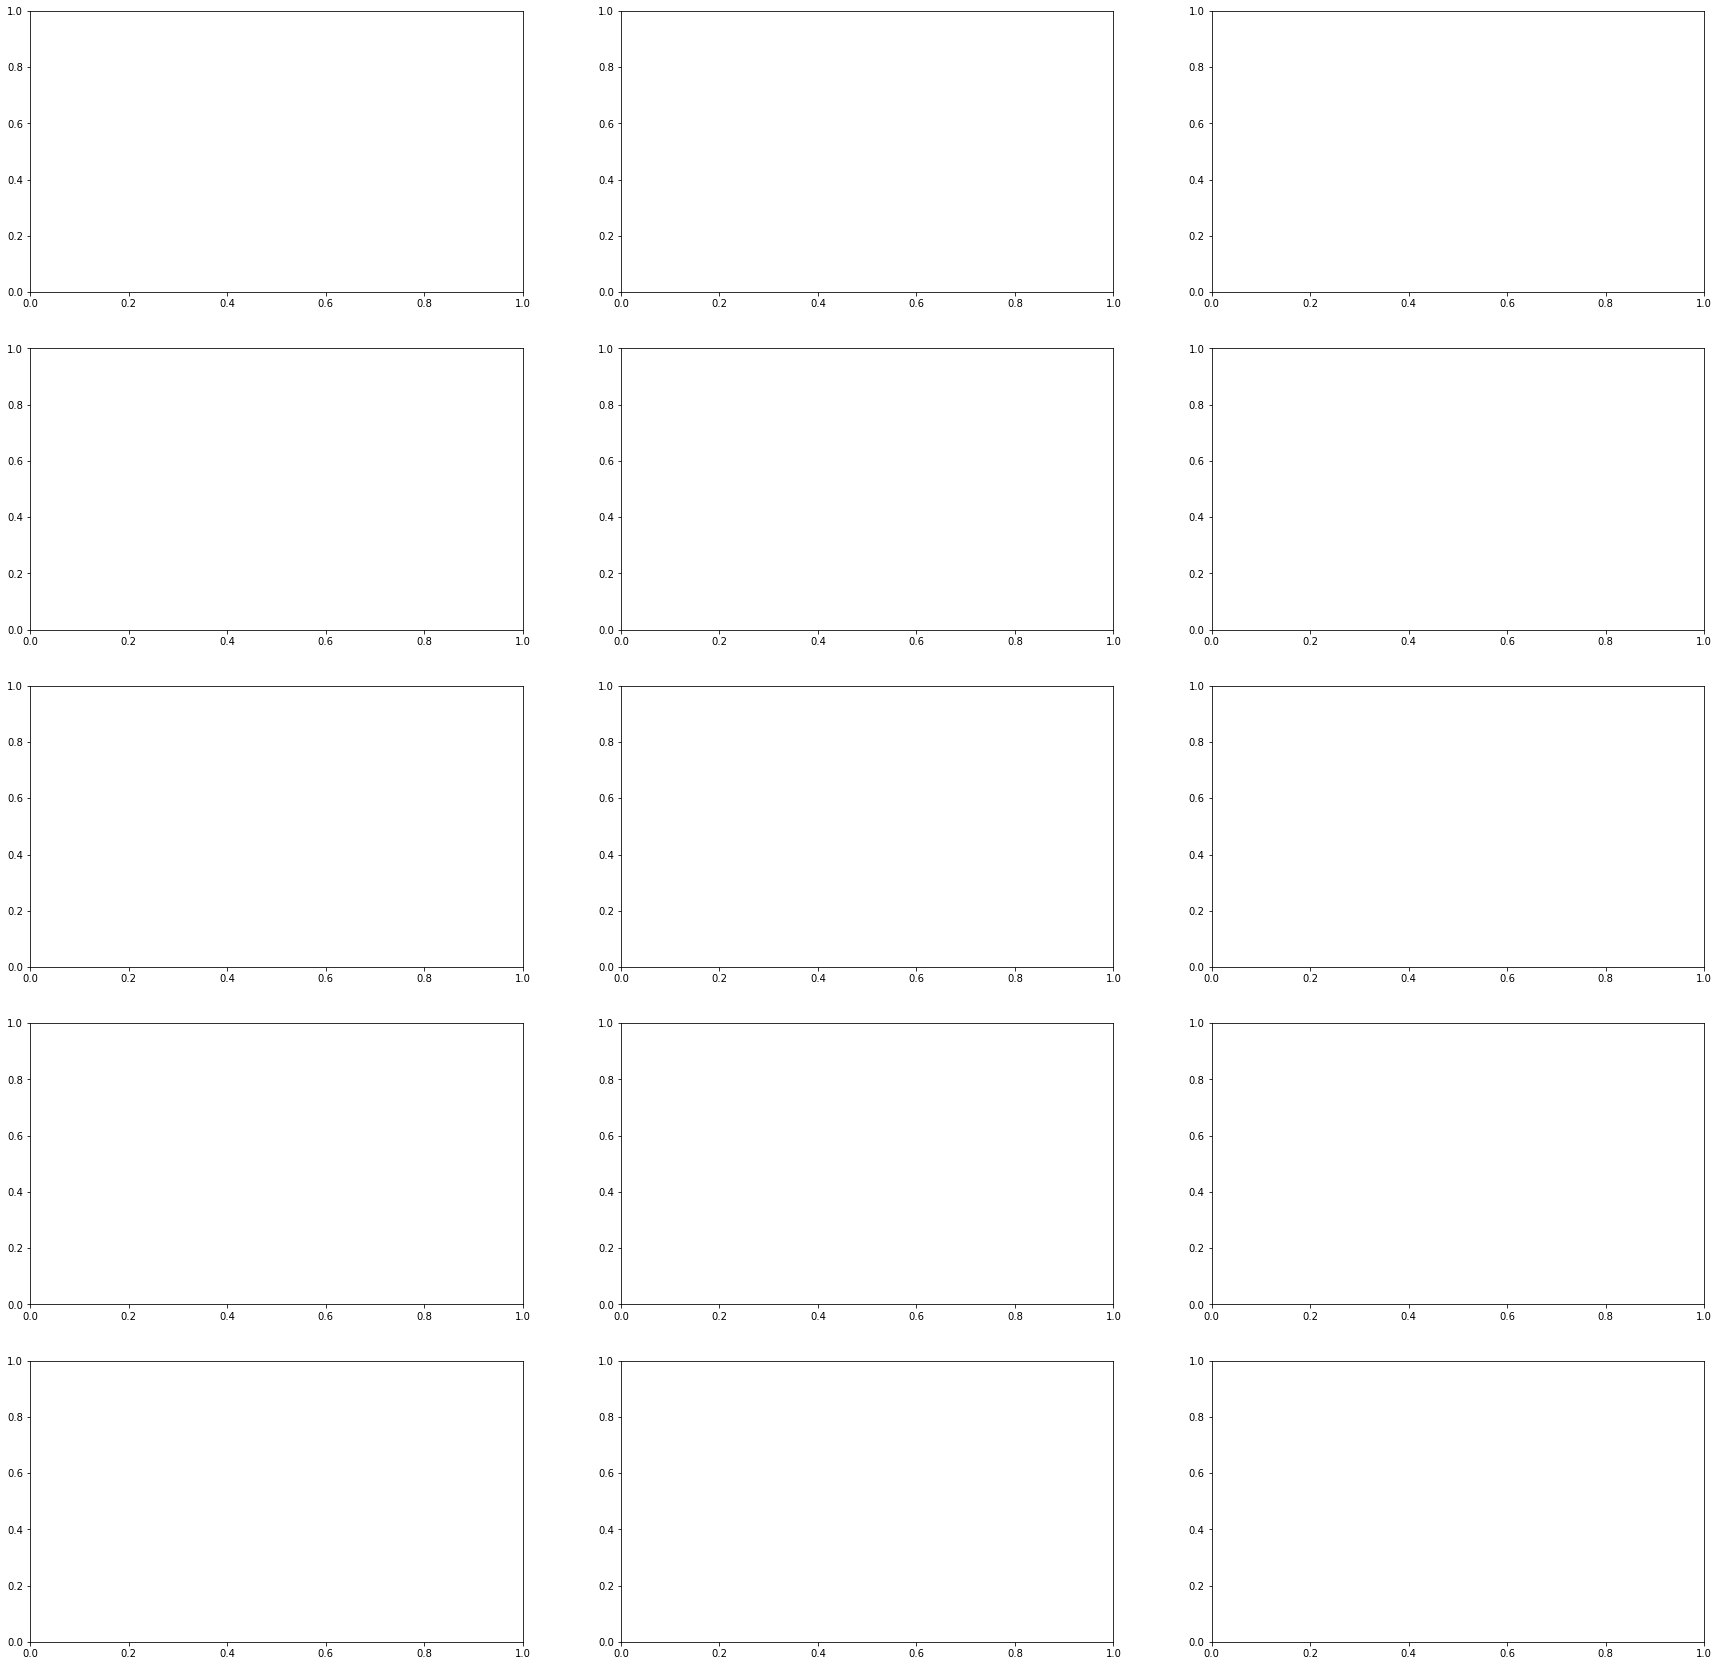

In [ ]:

df = pd.read_csv(path.ground_truth)
df = df.head(5)
fig, ax = plt.subplots(figsize = (30,30), nrows = 5, ncols = 3)
for index, line in df.iterrows():
    id_ = line['image_id'] 
    thresh = plt.imread(path.images+f'{id_}.jpg',0)
    mask = plt.imread(path.segmentation +f'{id_}_segmentation.png')
    x,y,z = boundry_check2(thresh, mask, 10,10)
    

fig.tight_layout

In [ ]:
df = pd.read_csv(path.ground_truth)
df = df.head(27)
for index, line in df.iterrows():
    id_ = line['image_id'] 
    thresh = plt.imread(path.images+f'{id_}.jpg',0)
    mask = plt.imread(path.segmentation +f'{id_}_segmentation.png')
    x,y,z = boundry_check2(thresh, mask, 10,10)
    print('id: ',f'{id_}', '\n', 'average of dark part:',x,'\n' ,'average boundry: ',y,'\n','average skind:',z)

id:  ISIC_0001769 
 average of dark part: [159.83842032  95.57834953  63.40961844] 
 average boundry:  [179.80081587 131.94565874 105.80983078] 
 average skind: [172.56400818 147.71291786 132.71414213]
id:  ISIC_0001852 
 average of dark part: [109.85679773  46.37205455  25.53741116] 
 average boundry:  [164.85409051 111.92310601  85.25608219] 
 average skind: [177.54102879 142.83262854 107.25255142]
id:  ISIC_0001871 
 average of dark part: [179.02100222 126.59109647  90.30315685] 
 average boundry:  [186.76657896 145.1945993  118.30798733] 
 average skind: [164.18216685 156.59280111 140.56389667]
id:  ISIC_0003462 
 average of dark part: [158.56646913 100.70443626  65.72013049] 
 average boundry:  [177.56282442 142.60593573 121.13967587] 
 average skind: [166.47889218 152.77070219 137.17889964]
id:  ISIC_0003539 
 average of dark part: [150.80213503  75.55936652  38.97565577] 
 average boundry:  [180.62973619 122.15677848  83.4048148 ] 
 average skind: [180.8234553  143.16784727 113.

In [17]:
mask = plt.imread('data/example_segmentation/ISIC_0003657_segmentation.png',0)
img =plt.imread('data/example_image/ISIC_0003657.jpg',0)
x,y,z = boundry_check2(img, mask, 10,10)
x_rgb = sRGBColor(x[0],x[1],x[2])
y_rgb = sRGBColor(y[0],y[1],y[2])
z_rgb = sRGBColor(z[0],z[1],z[2])

colorx_lab = convert_color(x_rgb, LabColor)
colory_lab = convert_color(y_rgb, LabColor)
colorz_lab = convert_color(z_rgb, LabColor)

print(delta_e_cie2000(colorx_lab, colory_lab))


12.47420947280999


In [ ]:
def variance_matrix(img, mask):
    # Make sure img is not cropped
    
    # Takes only red values to reduce computations
    red_channel = img[:,:,2]    
    print
    
    # only runs in masked perimiter to further reduce values
    a,b,c,d = util.extract_bboxes(mask)
    morphology.square(11)
    print(img[11+a:11-a,11+c:c-11])
    variance_list = []
    
    for i in range(a,b,22):
        for y in range(c,d,22):
            img_square = img[i-11:i+11,y-11:y+11]
            variance = np.var(img_square)
            variance_list.append(variance)
            
    varianceMatrix = ndimage.generic_filter(red_channel[mask == 1], np.var, size =11)
    return np.average(variance_list)

img = plt.imread('data/example_image/ISIC_0001769.jpg')
mask = plt.imread('data/example_segmentation/ISIC_0001769_segmentation.png')
a,b,c,d = util.extract_bboxes(mask)
plt.imshow(mask[a:b, c:d])


variance_matrix(img,mask)
